# Pneumonia Detection from Chest X-Ray Scans with Deep Learning

In [2]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

### Load/Scale Data

In [3]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 5865 files belonging to 2 classes.


In [4]:
data = data.map(lambda x,y: (x/255, y))

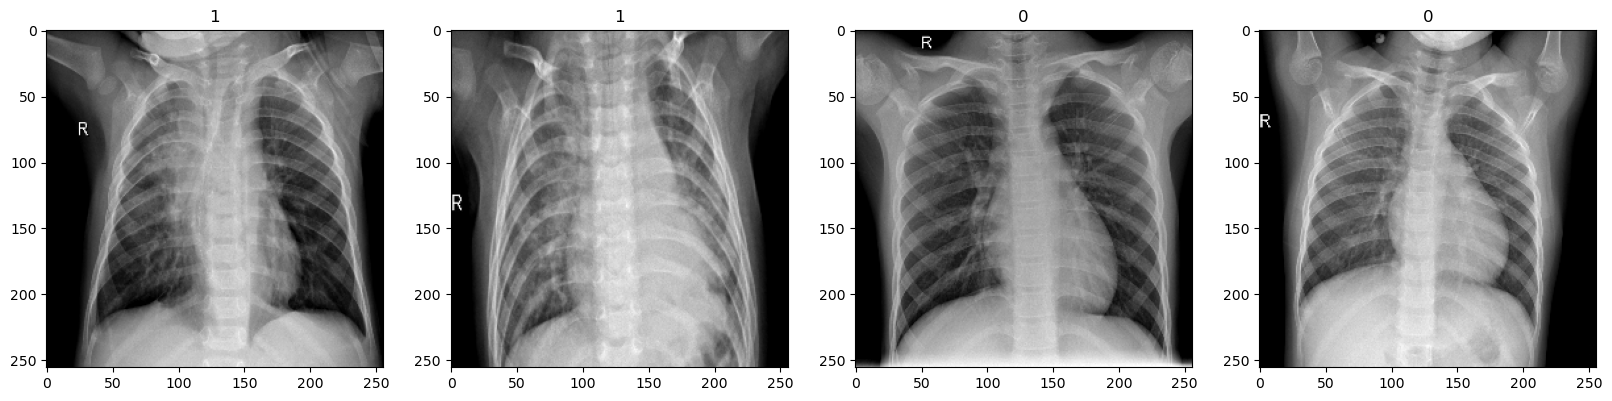

In [7]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### Split Data

In [5]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [6]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Build Model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import regularizers

In [8]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(1, activation='sigmoid'))

In [9]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

### Train Model

In [11]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [12]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
128/128 [==============================] - 92s 705ms/step - loss: 4.5392 - accuracy: 0.7473 - val_loss: 1.1139 - val_accuracy: 0.8184
Epoch 2/20
128/128 [==============================] - 86s 664ms/step - loss: 1.0934 - accuracy: 0.8486 - val_loss: 0.9651 - val_accuracy: 0.9029
Epoch 3/20
128/128 [==============================] - 83s 640ms/step - loss: 1.0088 - accuracy: 0.8926 - val_loss: 0.9740 - val_accuracy: 0.8818
Epoch 4/20
128/128 [==============================] - 82s 635ms/step - loss: 0.8840 - accuracy: 0.9121 - val_loss: 0.9923 - val_accuracy: 0.8792
Epoch 5/20
128/128 [==============================] - 85s 655ms/step - loss: 0.8413 - accuracy: 0.9224 - val_loss: 0.7918 - val_accuracy: 0.9299
Epoch 6/20
128/128 [==============================] - 83s 644ms/step - loss: 0.8069 - accuracy: 0.9224 - val_loss: 0.7487 - val_accuracy: 0.9451
Epoch 7/20
128/128 [==============================] - 82s 638ms/step - loss: 0.7649 - accuracy: 0.9285 - val_loss: 0.7848 - val_ac

### Evaluate Model

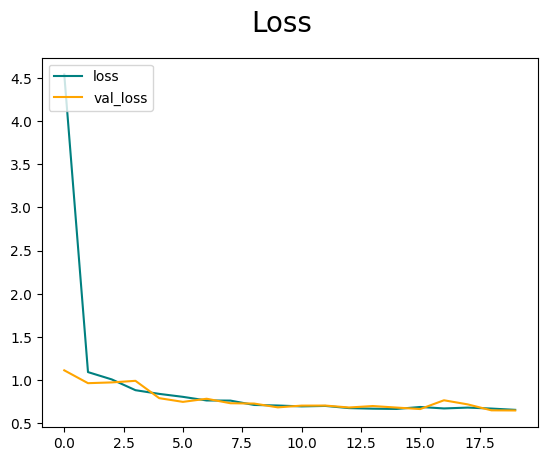

In [13]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

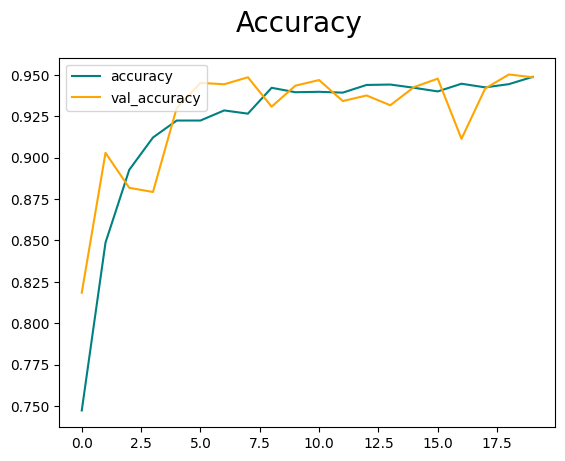

In [14]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [15]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [16]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [17]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 74ms/step


In [18]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9376344084739685, Recall:0.9753915071487427, Accuracy:0.9316239356994629


### Save Model

In [19]:
from tensorflow.keras.models import load_model

In [20]:
model.save(os.path.join('models','pneumoniaclassifier.h5'))
new_model = load_model(os.path.join('models','pneumoniaclassifier.h5'))

/Users/samiahmad/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Test Model

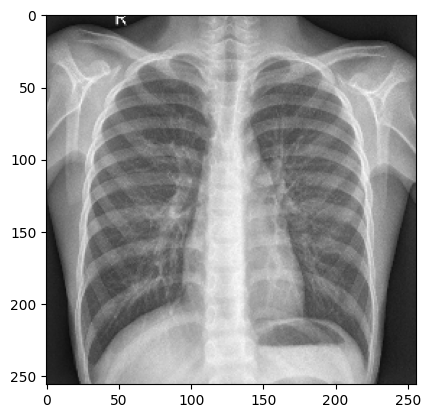

In [21]:
img = cv2.imread(image_path)
resizedimg = tf.image.resize(img, (256,256))
plt.imshow(resizedimg.numpy().astype(int))
plt.show()

In [22]:
yhat = new_model.predict(np.expand_dims(resizedimg/255, 0))
if yhat > 0.5: 
    print(f'Predicted class is Pneumonia')
else:
    print(f'Predicted class is Normal')

1/1 [==============================] - 0s 50ms/step
Predicted class is Normal


In [23]:
#import pickle
#load_model(os.path.join('models','pneumoniaclassifier.h5'))
#model=load_model(os.path.join('models','pneumoniaclassifier.h5'))
#spickle.dump(model, open('model.pk1','wb'))